In [255]:
import numpy as np
from scipy import stats, special, integrate
import matplotlib.pyplot as plt
import seaborn as sns

## Model

Full model:

\begin{align}
P_{L_1} ( A, \theta_{tall}, \theta_{short} \mid u ) & \propto P_{S_1} ( u \mid A, \theta_{tall}, \theta_{short} ) P_{L_1} (A) p(\theta_{tall}) p(\theta_{short}) \\
P_{S_1} ( u \mid A, \theta_{tall}, \theta_{short} ) & = \frac{e^{ \alpha (\log ( P_{L_0} (A \mid u, \theta_{tall}, \theta_{short} ) ) - C(u) ) }}{\sum_u e^{ \alpha ( \log ( P_{L_0} (A \mid u, \theta_{tall}, \theta_{short} ) ) - C(u) ) }}
\\
P_{L_0} ( A \mid u, \theta_{tall}, \theta_{short} ) & = P_{L_0} ( A \mid [u]^{\theta_{tall}, \theta_{short} } = 1 )
\end{align}

Simplification:

$$
e^{ \alpha \log ( P_{L_0} (A \mid u, \theta_{tall}, \theta_{short} ) ) - \alpha C(u) } \\
= e^{ \log ( P_{L_0} (A \mid u, \theta_{tall}, \theta_{short} )^{\alpha} ) } e^{- \alpha C(u)} \\
= P_{L_0} (A \mid u, \theta_{tall}, \theta_{short} )^{\alpha}  e^{- \alpha C(u)}
$$

- $P_{L_0} ( A \mid [u]^{\theta_{tall}} = 1 )$ is the integral from $\theta_{tall}$ to $\infty$ of $P(A)$
- $P_{L_0} ( A \mid [u]^{\theta_{short}} = 1 )$ is the integral from $-\infty$ to $\theta_{tall}$ of $P(A)$
- $\alpha = 4$
- Alternative utterances: {$A_{pos}$, $A_{neg}$, silence}
- $P(\theta_A)$ is uniform in [0, 1] for any adjective A
- $C(u) = 2/3 \times length(u)$. This means: C(silence) = 0, C(tall, short) = 2
- For relative standard adjectives: $P(A) = N(0.5, 0.15) $ truncated in [0,1]
- $p(\theta_{tall})$ and $p(\theta_{short})$ are uniform in the unit interval

In [152]:
def pragmatic_listener(degree, theta_short, theta_tall, prior_A, alpha=4, index_signal=1):
    """
    Return a tuple with the (unnormalized) probability of that combination of input parameters 
    given sent signals [short, tall].
    """
    
    cost_silence = 0
    cost_tall = 4/3
    cost_short = 4/3
    
    # probability of degree for literal listener if thetas are as input
    p_L0_short = prior_A.pdf(degree) / prior_A.cdf(theta_short) if degree < theta_short else 0.
    p_L0_tall = prior_A.pdf(degree) / prior_A.sf(theta_tall) if degree > theta_tall else 0.
    p_L0_silence = prior_A.pdf(degree)
    
    unnorm_p_s1_short = (p_L0_short ** alpha) * np.exp(-alpha*cost_short)
    unnorm_p_s1_tall = (p_L0_tall ** alpha) * np.exp(-alpha*cost_tall)
    unnorm_p_s1_silence = (p_L0_silence ** alpha) * np.exp(-alpha*cost_silence)
    
    s1_normalization_constant = unnorm_p_s1_short + unnorm_p_s1_tall + unnorm_p_s1_silence
    
    # probability for listener of that combination of degree, theta_tall, and theta_short
    # given the two possible signals "short" and "tall"
    l_1 = np.array(
        [unnorm_p_s1_short, unnorm_p_s1_tall, unnorm_p_s1_silence]) / s1_normalization_constant * prior_A.pdf(degree)

    return l_1[index_signal]

## Rough and ready MCMC

In [267]:
def MCMC(prior_property, index_signal):
    """
    Arguments
    ---------
    index_signal: int
        0 for "short" and 1 for "tall"
    """
    
    point = np.array([0.5, 0.5, 0.5])
    point_prob = pragmatic_listener(*point, prior_property, alpha=4, index_signal=index_signal)
    
    samples = []
    for i in range(500000):
        
        while True:
            proposal = np.random.normal(loc=point, scale=0.01)
            if np.all((proposal > 0) & (proposal < 1)):
                break
        
        proposal_prob = pragmatic_listener(*proposal, prior_property, alpha=4, index_signal=index_signal)
        
        acceptance_ratio = proposal_prob / point_prob
        
        if np.random.uniform() <= acceptance_ratio:
            point = proposal
            point_prob = proposal_prob
            
        samples.append(point)
            
    return np.array(samples)

# Figures

In [327]:
def draw(results, adj_name, index_signal_to_plot, ax, prior_property, burn_in=1000):
    """
    Arguments
    ---------
    results: array
        Array containing the results of the MCMC run from function above.
    adj_name: str
        String with the name of the signal. E.g. "tall" or "short"
    index_signal_to_plot: int
        1 for negative adjective and 2 for positive adjective
    ax: plt ax object
        Ax on which to plot results
    prior_property: scipy dist object
        As long as it has a pdf method, it's all good
    burn_in: int
        Number of initial MCMC samples to discard
        
    Returns
    -------
    None
    """
    
    sample_degree, to_plot = results.T[(0, index_signal_to_plot),:]

    sns.kdeplot(
        sample_degree[burn_in:], 
        color="blue", 
        clip=(0,1), 
        label="$p($ degree $\mid$ \"{}\" $)$".format(adj_name), 
        ax=ax
    )
    # CAREFUL TO PLOT THE SIGNAL THAT YOU RUN THE MCMC FOR!
    sns.kdeplot(
        to_plot[burn_in:], 
        color="green", 
        clip=(0,1), 
        label="$p($ transition $\mid$ \"{}\" $)$".format(adj_name), 
        ax=ax
    )

    xs = np.linspace(0, 1, 1000)
    ys = prior_property.pdf(xs)
    ax.plot(xs, ys, color="red", label="$p($ degree $)$")

    legend = ax.legend(fontsize="small")
    legend_frame = legend.get_frame()
    legend_frame.set_facecolor("white")
    ax.set_xlabel("Degrees")
    ax.set_ylabel("Density")

    for text in ["top", "left", "right"]:
        ax.spines[text].set_visible(False)
    ax.set_yticks([])

### Figure 1. & left part of Figure 2 (for thesis)

In [301]:
#### RELATIVE ADJECTIVE'S DISTRIBUTION (FIG. 1)
myclip_a = 0
myclip_b = 1
my_mean = 0.5
my_std = 0.15
a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
prior_property_tall = stats.truncnorm(a=a, b=b, loc=my_mean, scale=my_std)

results_relative_tall = MCMC(prior_property, index_signal=1)

In [302]:
#### HALF-OPEN SCALE ADJECTIVE'S DISTRIBUTION (FIG. 2)
prior_property_dangerous = stats.beta(a=1, b=9)

results_absolute_dangerous = MCMC(prior_property, index_signal=1)

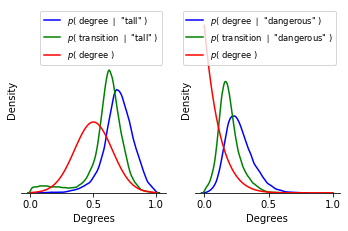

In [331]:
fig, (ax1, ax2) = plt.subplots(1,2)

draw(results_relative_tall, "tall", 2, ax1, prior_property_tall)
draw(results_absolute_dangerous, "dangerous", 2, ax2, prior_property_dangerous)

ax1.set_ylim(0,7)
ax2.set_ylim(0, 10)

w = 5.708
fig.set_size_inches(w, w*0.6)
plt.savefig("lassiterGoodman2013.png", dpi=300)

### Figure 3

In [174]:
### CLOSED SCALE (FIG. 3)
prior_property = stats.uniform()

### Figure 4

In [ ]:
#### SOME PRESSURE (FIG. 4)
myclip_a = 0
myclip_b = 1
my_mean = 0.25
my_std = 0.15
a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
prior_property = stats.truncnorm(a=a, b=b, loc=my_mean, scale=my_std)